# Case Neoway - Regressor Baseline

In [1]:
import os, sys

sys.path.append('../')
os.chdir('../')

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from src.base.commons import load_yaml,load_json, load_pickle, dump_pickle
from src.base.logger import logging
from src.global_variables import FEATURE_PARAMETERS_FILE, FILEPATHS_FILE, PARAMETERS_FILE, MODEL_CONFIG_FILE

from src.model import preprocessing, data


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [18]:
# !pip install shap
import shap

In [4]:
%config IPCompleter.use_jedi=False

pd.options.display.max_columns = None

In [123]:
import matplotlib.colors


def hex_to_rgb(h:str) -> tuple:
    """
    Converts an hex color code to rgb tuple.
    """
    return tuple(int(h.replace("#", "")[i : i + 2], 16) / 255 for i in (0, 2, 4))


def define_colormap(color_list:list) -> matplotlib.colors.ListedColormap:
    """
    Receives a list of hex colors an defines an matplotlib color map.
    """

    color_list = list(map(hex_to_rgb, color_list))

    cim = np.transpose(
        np.array(
            [
                np.concatenate(
                    [
                        np.linspace(color_list[j][i], color_list[j + 1][i], 100)
                        for j in range(len(color_list) - 1)
                    ]
                )
                for i in range(3)
            ]
        )
    )

    cmap = matplotlib.colors.ListedColormap(cim)

    return cmap


def remove_internal_correlations(
    features: pd.DataFrame,
    target: pd.Series,
    max_intern_corr: float,
    min_target_corr: float,
):
    """
    Receives a dataframe with the features and a series with the target
    and returns the name of features the are minimally correlated to
    target and non mutually colinear.
    """

    data = features.assign(target=target)

    data_corr = data.corr()

    sorted_cols = (
        data_corr["target"].drop(index="target").abs().sort_values(ascending=False)
    )

    sorted_cols = list(sorted_cols[sorted_cols > min_target_corr].index)

    drop = []

    for col in sorted_cols:
        if col not in drop:
            df_temp = data_corr.drop(index=["target", col])
            drop = drop + list(df_temp[df_temp[col].abs() > max_intern_corr][col].index)

    return (
        data[sorted_cols + ["target"]]
        .drop(columns=list(np.unique(drop)) + ["target"], errors="ignore")
        .columns
    )

In [10]:
#Importando modelo
model = load_pickle('model/lightgbm/regressor.pickle')

In [140]:
# Importando dados
X_train_transf = pd.read_parquet('data/processed/X_train_transf.parquet')
X_validation_transf = pd.read_parquet('data/processed/X_validation_transf.parquet')
X_pred_transf = pd.read_parquet('data/processed/X_pred_transf.parquet')

y_train = pd.read_parquet('data/processed/y_train.parquet')['prob_V1_V2']
y_validation = pd.read_parquet('data/processed/y_validation.parquet')['prob_V1_V2']

In [141]:
final_cols = remove_internal_correlations(
    X_train_transf,
    y_train,
    max_intern_corr = 0.70,
    min_target_corr = 0.05,
)

final_cols

Index(['V1_trabalha', 'proximidade_visita_casual', 'V1_pratica_esportes',
       'V2_transporte_mais_utilizado_particular', 'grau_familia',
       'proximidade_visita_rara', 'V1_estado_civil_casado_ou_divorciado',
       'V1_estuda', 'V1_transporte_mais_utilizado_publico',
       'V1_geracao_silent'],
      dtype='object')

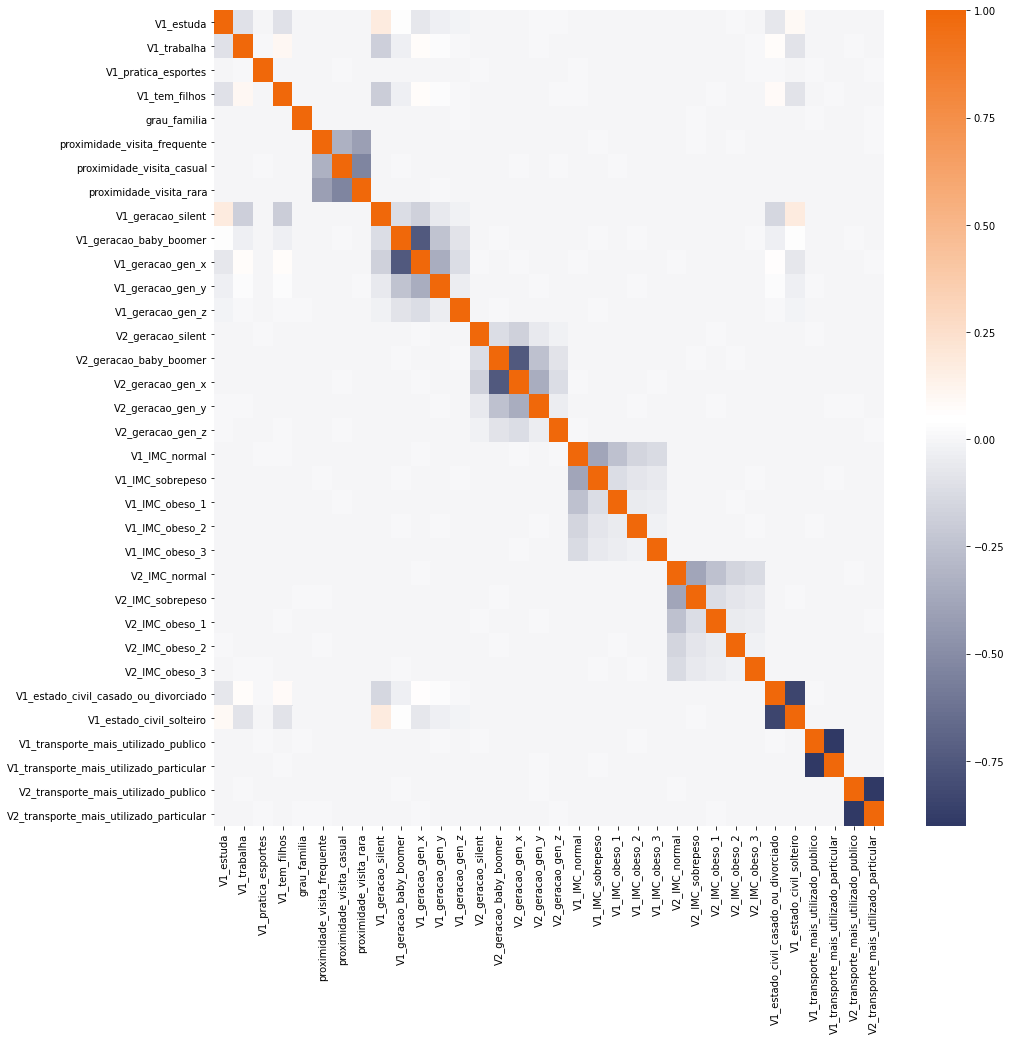

In [144]:
import seaborn as sns
import matplotlib.pyplot


colors = ['#303965','#ffffff','#f0680a']

plt.figure(figsize=(15,15))
sns.heatmap(X_train_transf.corr(), cmap=define_colormap(colors), annot=False)
plt.show()

# Shap Values

In [169]:
path = 'model/lightgbm/shap_values.pickle'
force_run = False

if force_run | (not os.path.exists(path)):

    X_temp = X_validation_transf.sample(10000)

    # Fits the explainer
    explainer = shap.Explainer(model.predict, X_temp)

    # Calculates the SHAP values - It takes some time
    shap_values = explainer(X_temp)
    
    dump_pickle(shap_values, path)

else:
    shap_values = load_pickle(path)

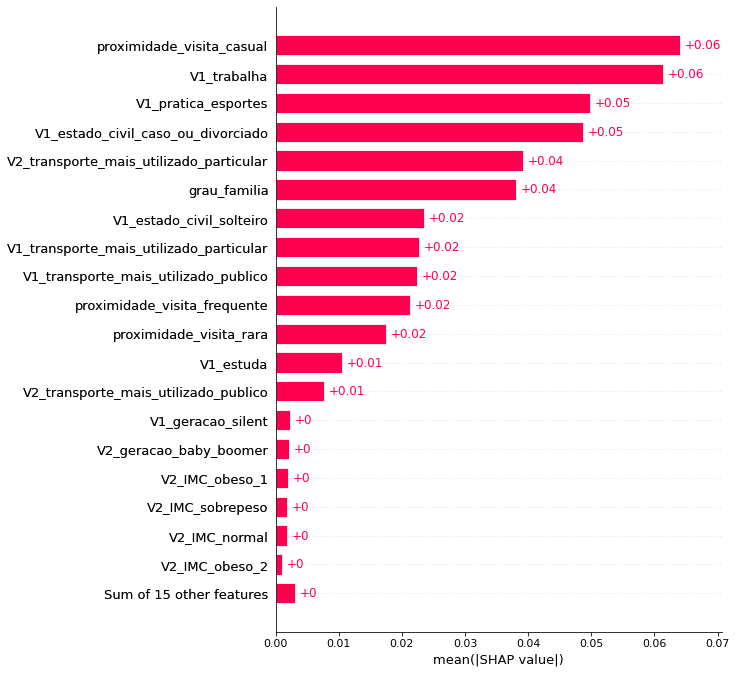

In [170]:
shap.plots.bar(shap_values, max_display=20)

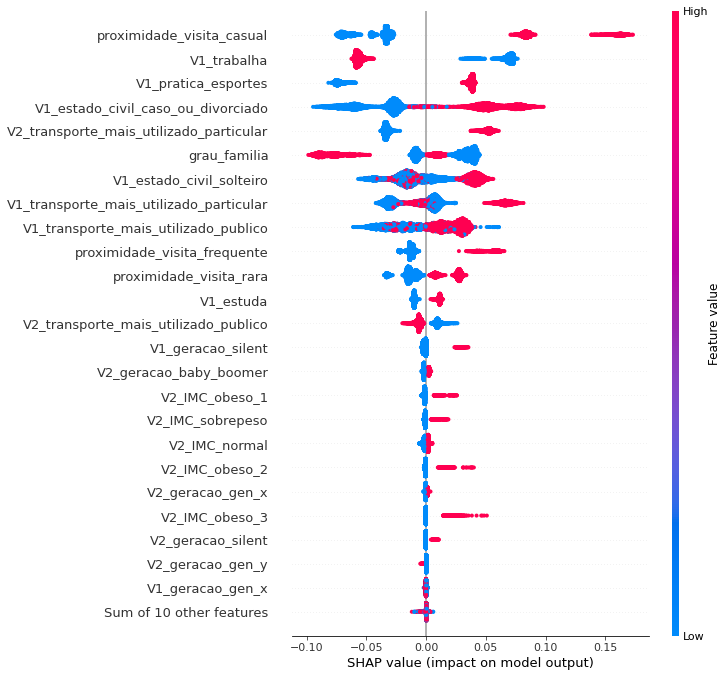

In [171]:
shap.plots.beeswarm(shap_values, max_display=25)

In [85]:
column = 'V1_trabalha'
print(y_train[X_train_transf[column]==0].mean())
print(y_train[X_train_transf[column]==1].mean())

0.5576708679755151
0.4282409965655509


In [86]:
column = 'V1_pratica_esportes'
print(y_train[X_train_transf[column]==0].mean())
print(y_train[X_train_transf[column]==1].mean())

0.41009834548312024
0.5238716726841987


In [87]:
column = 'V1_estado_civil_caso_ou_divorciado'
print(y_train[X_train_transf[column]==0].mean())
print(y_train[X_train_transf[column]==1].mean())

0.45698244271865646
0.5209854878857065


In [88]:
column = 'V2_transporte_mais_utilizado_particular'
print(y_train[X_train_transf[column]==0].mean())
print(y_train[X_train_transf[column]==1].mean())

0.45136135368165115
0.5527193630877245


In [89]:
column = 'grau_familia'
print(y_train[X_train_transf[column]==0].mean())
print(y_train[X_train_transf[column]==1].mean())

0.5121885747726758
0.4313882573050183
